In [2]:
# from ConCirclesVconst.py
# mjm June 16, 2016
#
# solve Poisson eqn with Vin = V0 and Vout = 0 for an annulus
# with inner radius r1, outer radius r2
# Vin = 10, Vout =0
#
from dolfin import *
#parameters["plotting_backend"] = "matplotlib"
#import logging
#logging.getLogger("FFC").setLevel(logging.WARNING)
from mshr import *  # need for Circle object to make annulus 
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [3]:
def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def mplot_cellfunction(cellfn):
    C = cellfn.array()
    tri = mesh2triang(cellfn.mesh())
    return plt.tripcolor(tri, facecolors=C)

def mplot_function(f):
    mesh = f.function_space().mesh()
    if (mesh.geometry().dim() != 2):
        raise AttributeError('Mesh must be 2D')
    # DG0 cellwise function
    if f.vector().size() == mesh.num_cells():
        C = f.vector().array()
        return plt.tripcolor(mesh2triang(mesh), C)
    # Scalar function, interpolated to vertices
    elif f.value_rank() == 0:
        C = f.compute_vertex_values(mesh)
        return plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    # Vector function, interpolated to vertices
    elif f.value_rank() == 1:
        w0 = f.compute_vertex_values(mesh)
        if (len(w0) != 2*mesh.num_vertices()):
            raise AttributeError('Vector field must be 2D')
        X = mesh.coordinates()[:, 0]
        Y = mesh.coordinates()[:, 1]
        U = w0[:mesh.num_vertices()]
        V = w0[mesh.num_vertices():]
        return plt.quiver(X,Y,U,V)

# Plot a generic dolfin object (if supported)
def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, Function):
        return mplot_function(obj)
    elif isinstance(obj, CellFunctionSizet):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionDouble):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionInt):
        return mplot_cellfunction(obj)
    elif isinstance(obj, Mesh):
        if (obj.geometry().dim() != 2):
            raise AttributeError('Mesh must be 2D')
        return plt.triplot(mesh2triang(obj), color='#808080')

    raise AttributeError('Failed to plot %s'%type(obj))

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


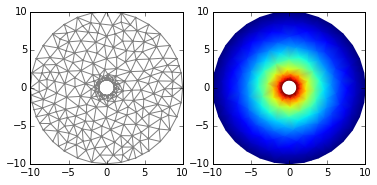

In [4]:
# next line *NEEDED* to extract solution at nodes
dolfin.parameters.reorder_dofs_serial = False

r1 = 1    # inner circle radius
r2 = 10   # outer circle radius

# shapes of inner/outer boundaries are circles
c1 = Circle(Point(0.0, 0.0), r1)
c2 = Circle(Point(0.0, 0.0), r2)

domain = c2 - c1  # solve between circles
res = 10
mesh = generate_mesh(domain, res)
#x1 = mesh.coordinates()[:,0]
#y1 = mesh.coordinates()[:,1]

class outer_boundary(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-2
		return on_boundary and (abs(sqrt(x[0]*x[0] + x[1]*x[1])) - r2) < tol

class inner_boundary(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-2
		return on_boundary and (abs(sqrt(x[0]*x[0] + x[1]*x[1])) - r1) < tol

outerradius = outer_boundary()
innerradius = inner_boundary()

boundaries = FacetFunction("size_t", mesh)

boundaries.set_all(0)
outerradius.mark(boundaries,2)
innerradius.mark(boundaries,1)

V = FunctionSpace(mesh,'Lagrange',1)

#nx = Expression('-x[1]*sin(ThetaInner)/sqrt(x[0]*x[0] + x[1]*x[1])',ThetaInner = -0.2)
n = Constant(10.0) 

bcs = [DirichletBC(V, 0, boundaries, 2),
	   DirichletBC(V, n, boundaries, 1)]
#	   DirichletBC(V, nx, boundaries, 1)]

u = TrialFunction(V)

v = TestFunction(V)
f = Constant(0.0)
a = inner(nabla_grad(u), nabla_grad(v))*dx
L = f*v*dx

u = Function(V)
solve(a == L, u, bcs)
plt.figure()
plt.subplot(1,2,1)
plot(mesh)
plt.subplot(1,2,2)
plot(u)

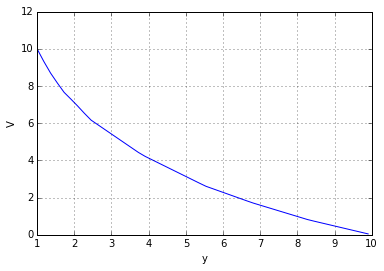

In [5]:
y = np.linspace(r1,r2*0.99)
uu = []
np.array(uu)
for i in range(len(y)):
    yy = y[i]
    #print(i,yy,u(0,yy))
    uu.append(u(0.0,yy))
plt.figure()
plt.plot(y,uu)
plt.grid(True)
plt.xlabel('y')
plt.ylabel('V')

# Evaluate the result at each point
Loop through the grid and evaluate at each point.
Ignore the points inside the circle or outside outer circle.

(10000, 10000, 10000)


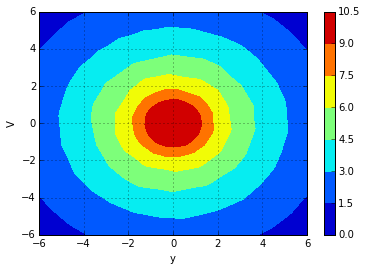

In [6]:
# we now evaluate V everywhere and make contour plot
xx = []
yy = []
uu = []
np.array(xx)
np.array(yy)
np.array(uu)
nx,ny = 100,100

for x in np.linspace(-6,6,nx):
    for y in np.linspace(-6,6,ny):
        r = sqrt(x**2+y**2)
#         print(x,y,r)
        if r <= r1:   # if inside inner boundary, set to V_inner
            xx.append(x)
            yy.append(y)
            uu.append(10.0)
            #print('out')
        elif r >= r2: # if outside outer boundary, set to V_outer
            xx.append(x)
            yy.append(y)
            uu.append(0.0)
            #print('out')
        else:
            xx.append(x)
            yy.append(y)
            uu.append(u(x,y))
            #print('in',u(x,y))
print(len(xx),len(yy),len(uu))
XX = np.reshape(xx,(nx,ny))
YY = np.reshape(yy,(nx,ny))
UU = np.reshape(uu,(nx,ny))
plt.figure()
plt.contourf(XX,YY,UU)
plt.grid(True)
plt.colorbar()
plt.xlabel('y')
plt.ylabel('V')

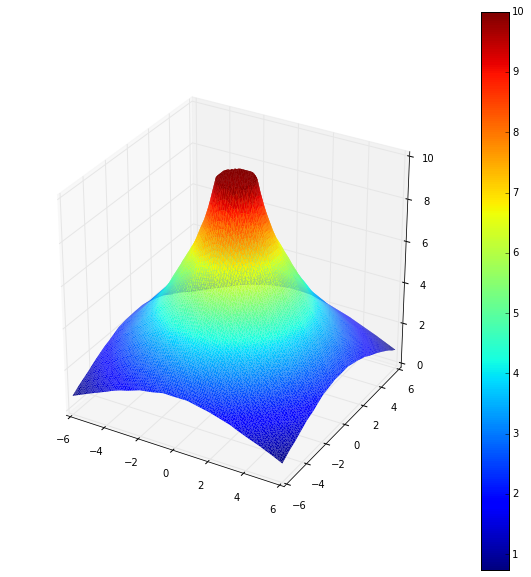

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(xx, yy, uu,cmap=cm.jet,linewidth=0)
# ax.view_init(90,90)
# surf.set_edgecolor('k')
ax.set_aspect('equal')
plt.colorbar(surf);